In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# EDA

In [8]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')

In [9]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [10]:
df = df.rename(columns={'Residence_type':'residence_type'})

In [11]:
# Converte genero para 0 ou 1
df['gender'] = df['gender'].apply({'Male':1, 'Female':0}.get)

In [12]:
# Converte status de se já foi casado para 0 ou 1
df['ever_married'] = df['ever_married'].apply({'Yes':1, 'No':0}.get)

In [15]:
# Converte o tipo de residência para 0 ou 1
df['residence_type'] = df['residence_type'].apply({'Rural':1, 'Urban':0}.get)

In [16]:
# modificando strings
df['smoking_status'] = df['smoking_status'].apply(str.lower)
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.replace(' ','_'))

In [17]:
# modificando strings
df['work_type'] = df['work_type'].apply(str.lower)
df['work_type'] = df['work_type'].apply(lambda x: x.replace('-','_'))

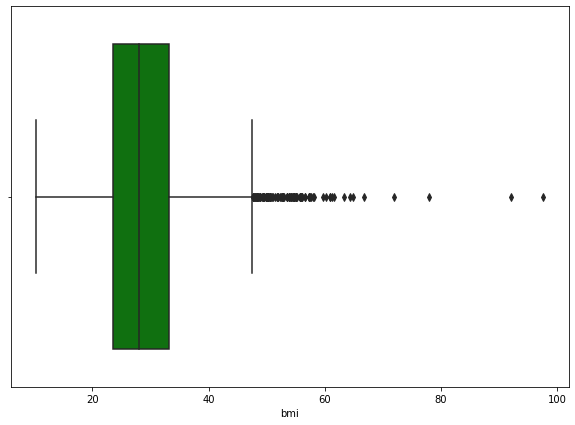

In [18]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df,x=df["bmi"],color='green');

In [19]:
df["bmi"] = df["bmi"].apply(lambda x: 50 if x>50 else x)
df["bmi"] = df["bmi"].fillna(28.4)

In [20]:
df = pd.get_dummies(df)

In [21]:
df = df[~df.isnull().any(axis=1)]

# **Heatmap Correlation**

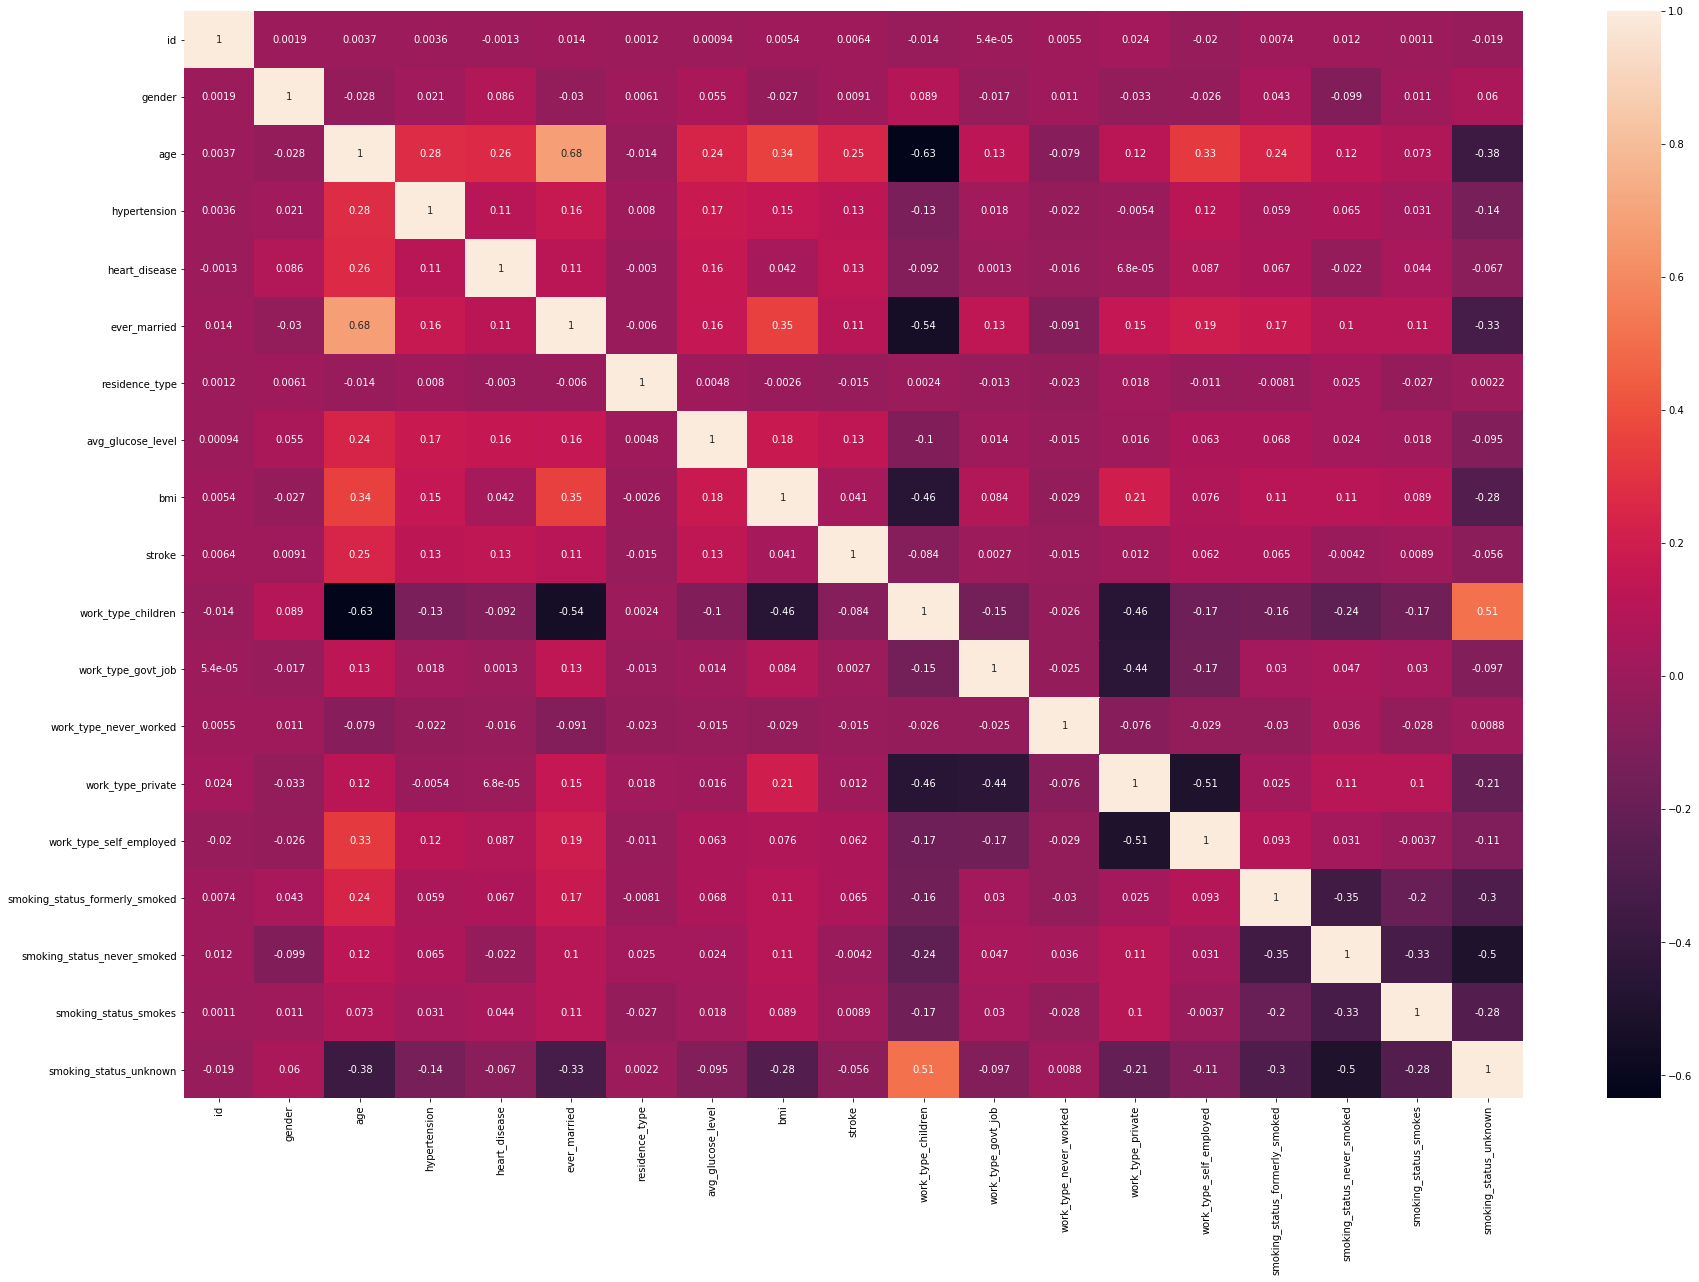

In [22]:
plt.figure(figsize = (30,20))
sns.heatmap(df.corr(),annot=True);

# Scaling The variance in Features

In [23]:
std=StandardScaler()
columns = ['avg_glucose_level','bmi','age']
scaled = std.fit_transform(df[['avg_glucose_level','bmi','age']])
scaled = pd.DataFrame(scaled,columns=columns)
df=df.drop(columns=columns,axis=1)

In [24]:
df=df.merge(scaled, left_index=True, right_index=True, how = "left")
df

,id,gender,hypertension,heart_disease,ever_married,residence_type,stroke,work_type_children,work_type_govt_job,work_type_never_worked,work_type_private,work_type_self_employed,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes,smoking_status_unknown,avg_glucose_level,bmi,age
0,9046,1.0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,2.706450,1.069148,1.051242
1,51676,0.0,0,0,1,1,1,0,0,0,0,1,0,1,0,0,2.121652,-0.051569,0.785889
2,31112,1.0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,-0.004867,0.508790,1.626174
3,60182,0.0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1.437473,0.768468,0.255182
4,1665,0.0,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1.501297,-0.652929,1.581949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0.0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0.420922,1.533836,1.670400
5106,44873,0.0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,-0.511266,0.249111,-0.363976
5107,19723,0.0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1.328375,-0.434252,0.343633
5108,37544,1.0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,-0.460692,-0.352249,0.034054


In [25]:
df = df[~df.isnull().any(axis=1)]

# Class

In [26]:
df_class = df.drop(['id','stroke'], axis=1)
df_target = df['stroke']

# Spliting

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_class, df_target, test_size=0.3, random_state=11)

In [28]:
y_test.value_counts()

0    1449
1      84
Name: stroke, dtype: int64

# adaboost classification

In [29]:
#create adaboost classification obj
ab_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, 
                            learning_rate=0.5, random_state=100)

#training via adaboost classficiation model
ab_clf.fit(X_train, y_train)
print("training....\n")

#make prediction using the test set
ab_pred_stroke= ab_clf.predict(X_train)
print('prediction: \n', ab_pred_stroke)

print('\nparms: \n', ab_clf.get_params)

#score
ab_clf_score = ab_clf.score(X_test, y_test)
print("\nmean accuracy: %.2f" % ab_clf.score(X_test, y_test))

training....

prediction: 
 [0 0 0 ... 0 0 0]

parms: 
 <bound method BaseEstimator.get_params of AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
    

# XGboost

Training Score 0.9619580419580419
Testing Score 
 0.9445531637312459
0.9445531637312459


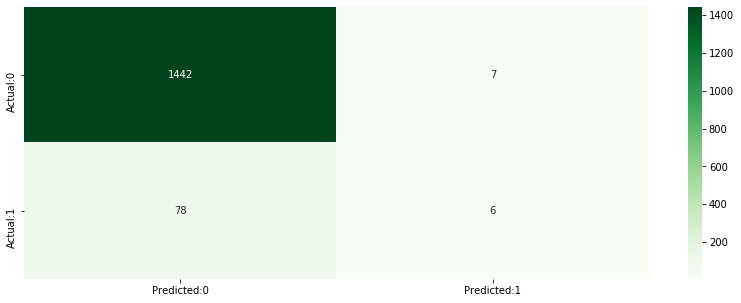

In [30]:
xgboost = GradientBoostingClassifier(random_state=0)
xgboost.fit(X_train, y_train)
#== 
#Score 
#== 
xgboost_score = xgboost.score(X_train, y_train)
xgboost_test = xgboost.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = xgboost.predict(X_test)
#== 
#evaluation
#== 
cm = confusion_matrix(y_test,y_pred)
print('Training Score',xgboost_score)
print('Testing Score \n',xgboost_test)

#=== 
#Confusion Matrix 
plt.figure(figsize=(14,5))

conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Greens");
print(accuracy_score(y_test,y_pred))

# SVM

Training Score 0.9538461538461539
Testing Score 
 0.9452054794520548
0.9452054794520548


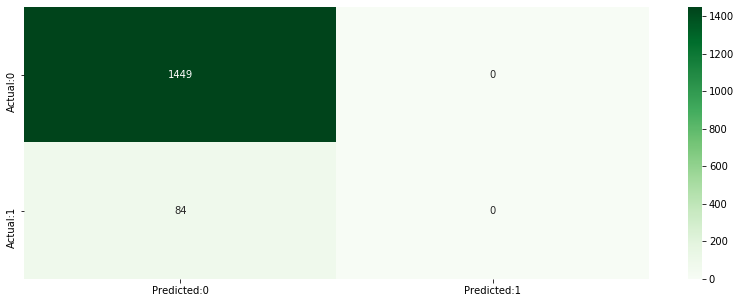

In [31]:
svc = SVC(random_state=0)
svc.fit(X_train, y_train)
#== 
#Score 
#== 
svc_score = svc.score(X_train, y_train)
svc_test = svc.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = svc.predict(X_test)
#== 
#evaluation
#== 
cm = confusion_matrix(y_test,y_pred)
print('Training Score',svc_score)
print('Testing Score \n',svc_test)

plt.figure(figsize=(14,5))

conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Greens");
print(accuracy_score(y_test,y_pred))

# Random Forest Classifier

Training Score 1.0
Testing Score 
 0.9432485322896281
0.9432485322896281


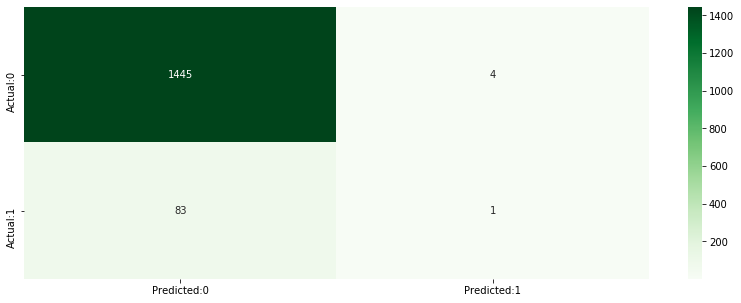

In [32]:
forest = RandomForestClassifier(n_estimators = 100)
#== 
forest.fit(X_train, y_train)
#== 
#Score 
#== 
forest_score = forest.score(X_train, y_train)
forest_test = forest.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = forest.predict(X_test)
#== 
#evaluation
#== 
cm = confusion_matrix(y_test,y_pred)
print('Training Score',forest_score)
print('Testing Score \n',forest_test)

plt.figure(figsize=(14,5))

conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Greens");
print(accuracy_score(y_test,y_pred))

# Logistic Regression

Training Score 0.9538461538461539
Testing Score 
 0.9458577951728636
0.9458577951728636


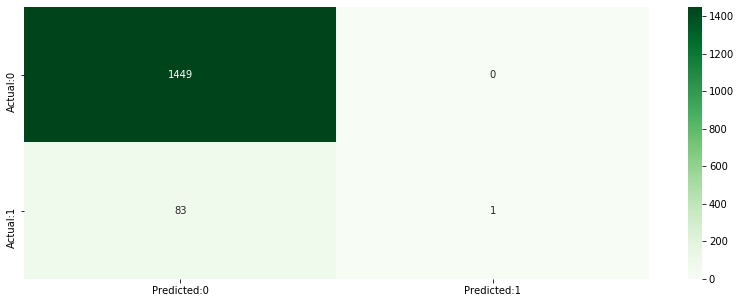

In [33]:
model = LogisticRegression()
model.fit(X_train, y_train)
#== 
#Score 
#== 
logistic_score = model.score(X_train, y_train)
logistic_test = model.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = model.predict(X_test)
#== 
#evaluation
#== 
cm = confusion_matrix(y_test,y_pred)
print('Training Score',logistic_score)
print('Testing Score \n',logistic_test)

plt.figure(figsize=(14,5))

conf_matrix = pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Greens");
print(accuracy_score(y_test,y_pred))

In [34]:
xgboost.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [40]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])


param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))},
    {'classifier' : [SVC()],
     'classifier__C': [0.1,1, 10, 100, 1000], 
     'classifier__gamma': [1,0.1,0.01,0.001, 0.0001],
     'classifier__kernel': ['rbf', 'poly', 'sigmoid']},
    {'classifier' : [GradientBoostingClassifier()],
    'classifier__max_depth' : [3,4,5]}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 178 candidates, totalling 890 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 548 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 890 out of 890 | elapsed: 45.6min finished


In [36]:
best_clf.best_params_

{'classifier': SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 'classifier__C': 100,
 'classifier__gamma': 0.1,
 'classifier__kernel': 'sigmoid'}

Training Score 0.9538461538461539
Testing Score 
 0.9452054794520548
0.9452054794520548
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1449
           1       0.00      0.00      0.00        84

    accuracy                           0.95      1533
   macro avg       0.47      0.50      0.49      1533
weighted avg       0.89      0.95      0.92      1533



/home/hashimoto/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


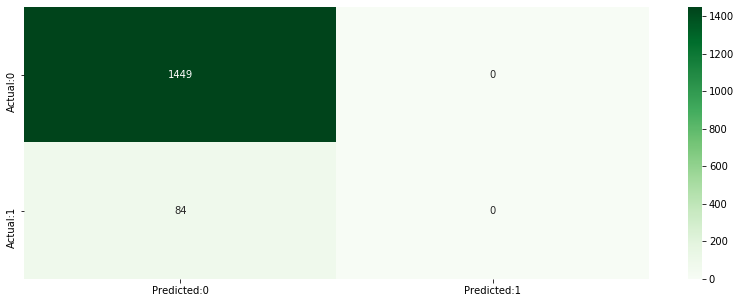

In [39]:
model = GradientBoostingClassifier(learning_rate = 0.01,
  loss = 'deviance',
  max_depth = 3,
  min_samples_leaf = 0.1,
  min_samples_split = 0.1,
  n_estimators = 10,
  subsample = 0.5)
model.fit(X_train, y_train)
#== 
#Score 
#== 
logistic_score = model.score(X_train, y_train)
logistic_test = model.score(X_test, y_test)
#== 
#testing model 
#== 
y_pred = model.predict(X_test)
#== 
#evaluation
#== 
cm = confusion_matrix(y_test,y_pred)
print('Training Score',logistic_score)
print('Testing Score \n',logistic_test)

plt.figure(figsize=(14,5))

conf_matrix = pd.DataFrame(data=cm,co umns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="Greens");
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
import pickle
filename = 'logistic_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
model.predict_proba([[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 100, 23, 50]])